In [1]:
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [3]:
movies.head()

,primarytitle,domesticgross,productionbudget,runtimeminutes,release_year,release_week,g_rating,pg_rating,pg13_rating,r_rating,...,guy_ritchie,david_gordon_green,christopher_nolan,todd_phillips,warner_bros,universal,fox,buena_vista,sony,paramount
0,"10,000 BC",94784201,105000000,109.0,2008,10,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,102 Dalmatians,66941559,85000000,100.0,2000,47,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,10 Cloverfield Lane,72082999,15000000,103.0,2016,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,10 Days in a Madhouse,14616,12000000,111.0,2015,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10th & Wolf,54702,8000000,107.0,2006,33,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
movies.describe()

,domesticgross,productionbudget,runtimeminutes,release_year,release_week,g_rating,pg_rating,pg13_rating,r_rating,action,...,guy_ritchie,david_gordon_green,christopher_nolan,todd_phillips,warner_bros,universal,fox,buena_vista,sony,paramount
count,2.788000e+03,2.788000e+03,2780.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.00000,...,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000
mean,5.933330e+07,4.549039e+07,107.426619,2009.068149,29.367288,0.025825,0.146341,0.353659,0.389885,0.26363,...,0.002869,0.003228,0.003228,0.003587,0.097202,0.086083,0.080703,0.069225,0.067791,0.060258
std,7.963726e+07,4.990510e+07,17.954723,5.507703,14.646044,0.158641,0.353512,0.478191,0.487812,0.44068,...,0.053500,0.056735,0.056735,0.059793,0.296286,0.280537,0.272427,0.253882,0.251431,0.238007
min,4.230000e+02,7.000000e+03,15.000000,2000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.184761e+07,1.200000e+07,95.000000,2004.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.401892e+07,2.910000e+07,105.000000,2009.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.343355e+07,6.000000e+07,117.000000,2014.000000,42.000000,0.000000,0.000000,1.000000,1.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.583730e+08,4.106000e+08,219.000000,2019.000000,53.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


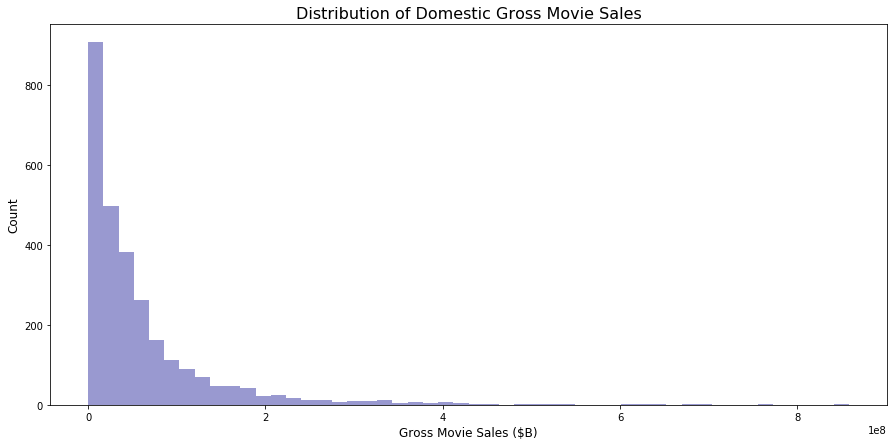

In [5]:
plt.figure(figsize=(15, 7))
sns.distplot(movies['domesticgross'], kde=False, color="darkblue")
plt.title("Distribution of Domestic Gross Movie Sales", fontsize=16)
plt.xlabel("Gross Movie Sales ($B)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('plots/sales_dist.png')

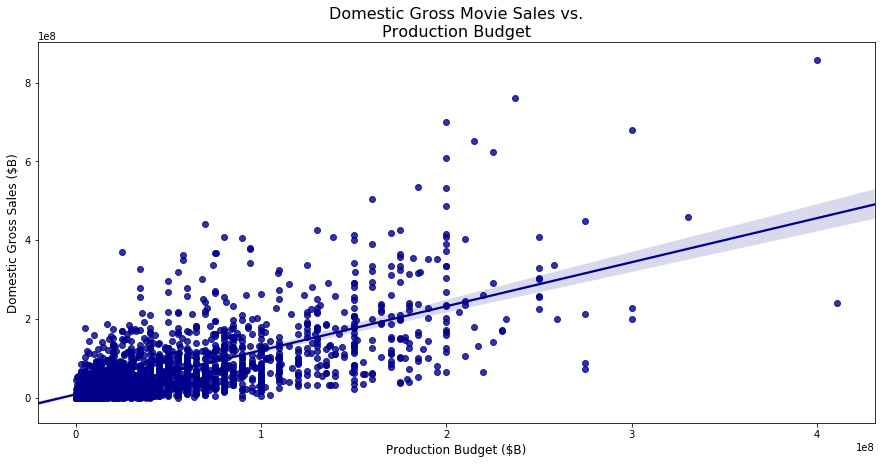

In [6]:
plt.figure(figsize=(15, 7))
sns.regplot(data=movies,x='productionbudget',y='domesticgross', color="darkblue")
plt.title("Domestic Gross Movie Sales vs.\nProduction Budget", fontsize=16)
plt.xlabel("Production Budget ($B)", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/sales_vs_budget.png')

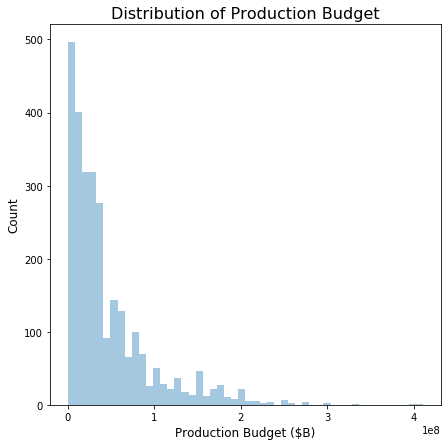

In [7]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['productionbudget'], kde=False)
plt.title("Distribution of Production Budget", fontsize=16)
plt.xlabel("Production Budget ($B)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('plots/budget_dist.png')

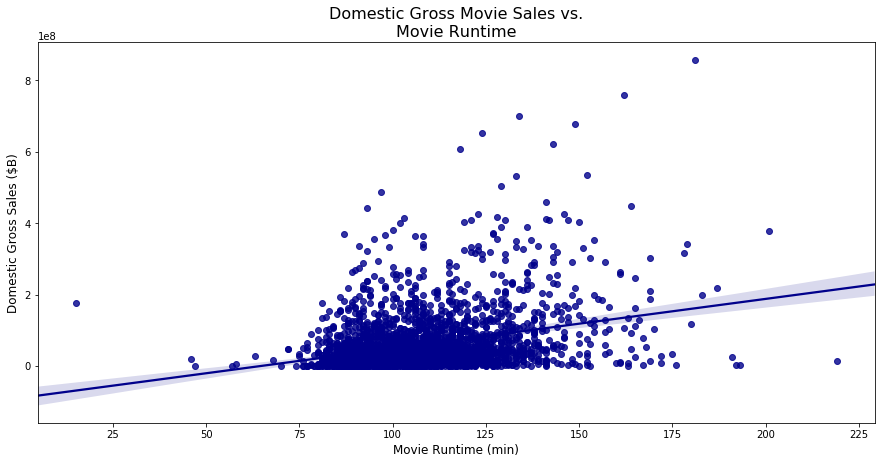

In [8]:
plt.figure(figsize=(15, 7))
sns.regplot(data=movies,x='runtimeminutes',y='domesticgross', color="darkblue")
plt.title("Domestic Gross Movie Sales vs.\nMovie Runtime", fontsize=16)
plt.xlabel("Movie Runtime (min)", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/sales_vs_runtime.png')

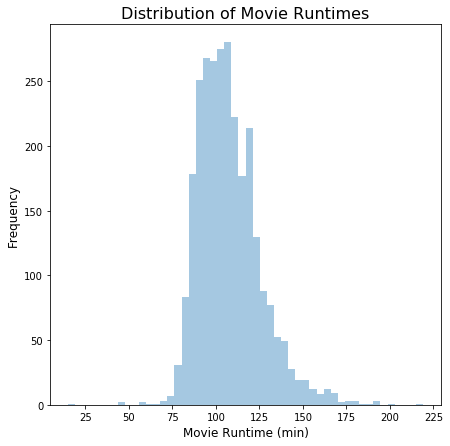

In [9]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['runtimeminutes'].dropna(), kde=False)
plt.title("Distribution of Movie Runtimes", fontsize=16)
plt.xlabel("Movie Runtime (min)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig('plots/runtimes_dist.png')

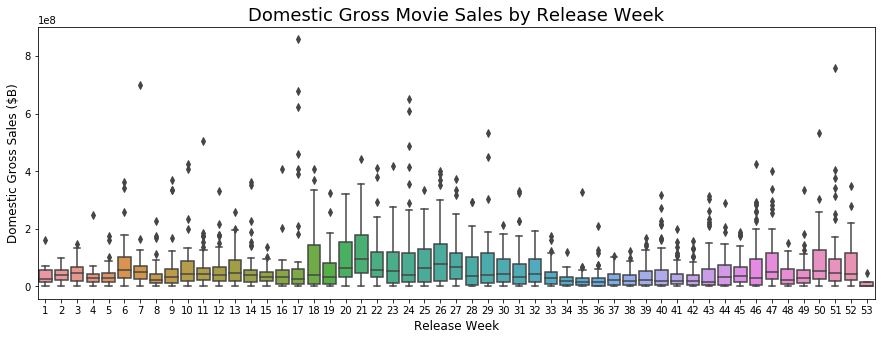

In [10]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_week")
plt.title("Domestic Gross Movie Sales by Release Week", fontsize=18)
plt.xlabel("Release Week", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/box_by_week.png')

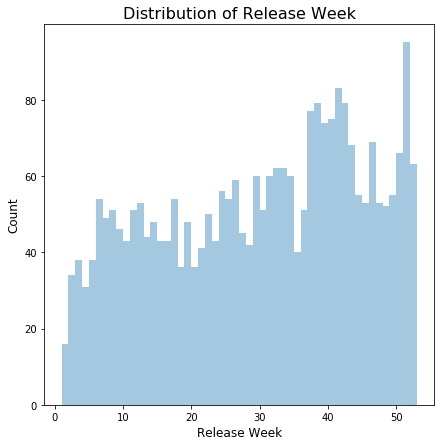

In [11]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['release_week'], kde=False, bins=52)
plt.title("Distribution of Release Week", fontsize=16)
plt.xlabel("Release Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('plots/week_dist.png')

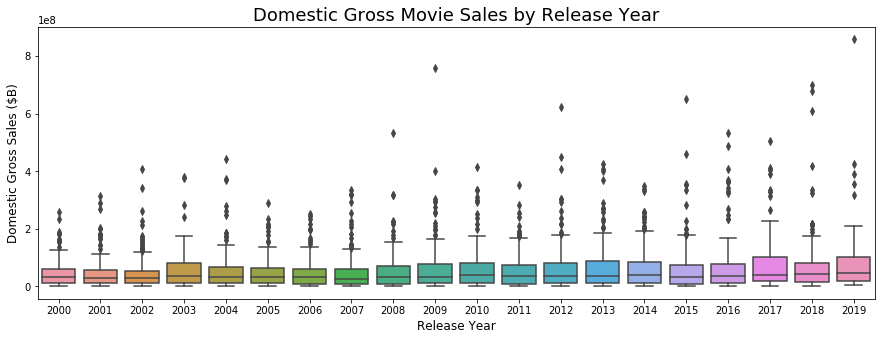

In [12]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year")
plt.title("Domestic Gross Movie Sales by Release Year", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/box_by_year.png')

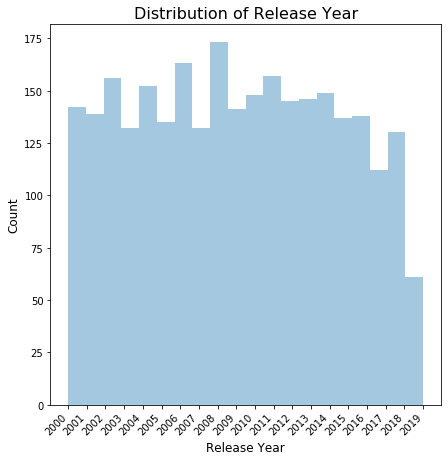

In [13]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['release_year'], kde=False, bins=20)
plt.title("Distribution of Release Year", fontsize=16)
plt.xticks(list(range(2000,2020)), rotation=45, horizontalalignment='right')
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('plots/year_dist.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


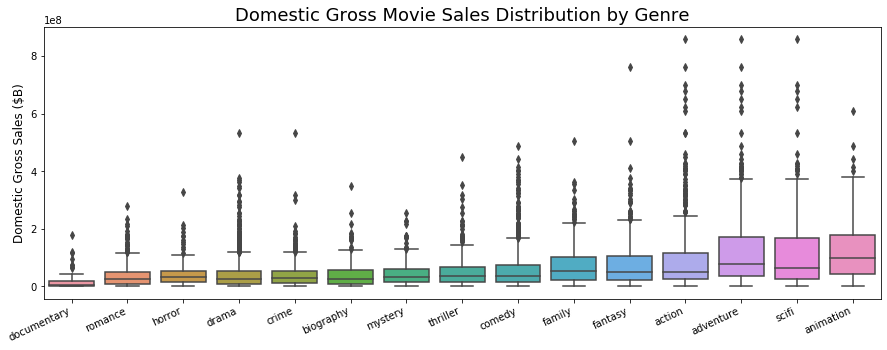

In [14]:
genre_list = ['action','comedy','drama','adventure','biography','horror','crime','documentary',
              'animation','romance','mystery','thriller','scifi','fantasy','family']
genre_df = movies[genre_list]

for genre in genre_list:
    genre_df[genre] = genre_df[genre] * movies['domesticgross']
 
genre_melt = genre_df.melt()
genre_melt = genre_melt[genre_melt['value']!=0]
result = genre_melt.groupby(['variable'])['value'].aggregate(np.mean).reset_index().sort_values('value')   

plt.figure(figsize=(15, 5))
sns.boxplot(data=genre_melt, y="value", x="variable", order=result['variable'])
plt.xticks(rotation=25, horizontalalignment='right')
plt.title("Domestic Gross Movie Sales Distribution by Genre", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/genre_sales.png')

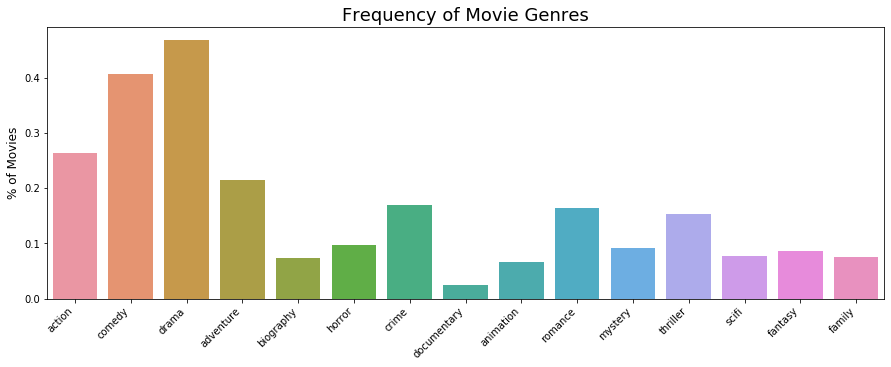

In [15]:
genre_list = ['action','comedy','drama','adventure','biography','horror','crime','documentary',
              'animation','romance','mystery','thriller','scifi','fantasy','family']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[genre_list].melt(), y="value", x="variable", ci=None) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movie Genres", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('plots/genre_freq.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


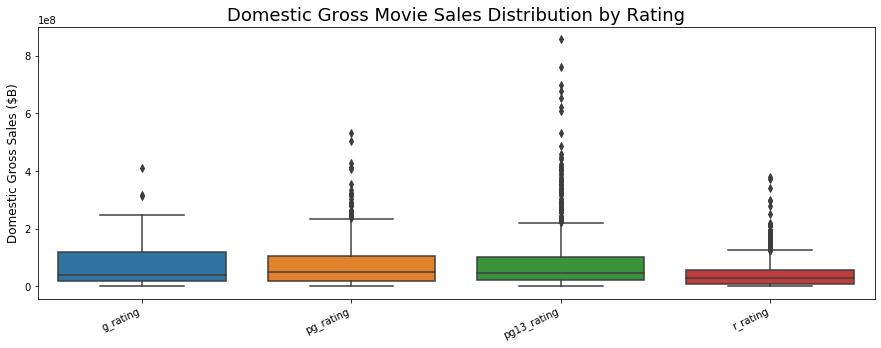

In [16]:
rating_list = ['g_rating','pg_rating','pg13_rating','r_rating']
rating_df = movies[rating_list]

for rating in rating_list:
    rating_df[rating] = rating_df[rating] * movies['domesticgross']

rating_melt = rating_df.melt()
rating_melt = rating_melt[rating_melt['value']!=0]

plt.figure(figsize=(15, 5))
sns.boxplot(data=rating_melt, y="value", x="variable")
plt.xticks(rotation=25, horizontalalignment='right')
plt.title("Domestic Gross Movie Sales Distribution by Rating", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/rating_sales.png')

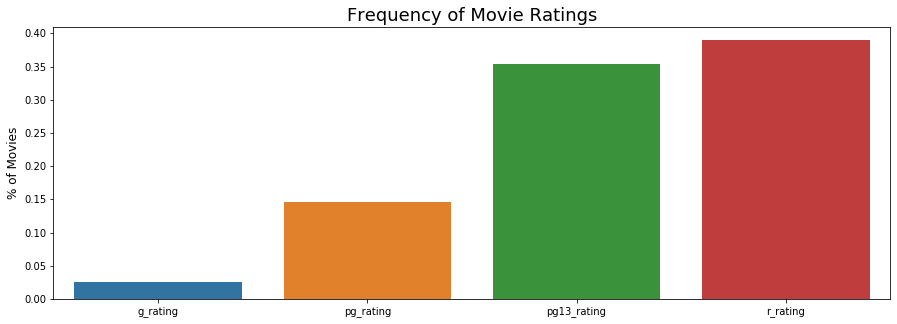

In [17]:
rating_list = ['g_rating','pg_rating','pg13_rating','r_rating']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[rating_list].melt(), y="value", x="variable", ci=None) 
plt.title("Frequency of Movie Ratings", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('plots/rating_freq.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


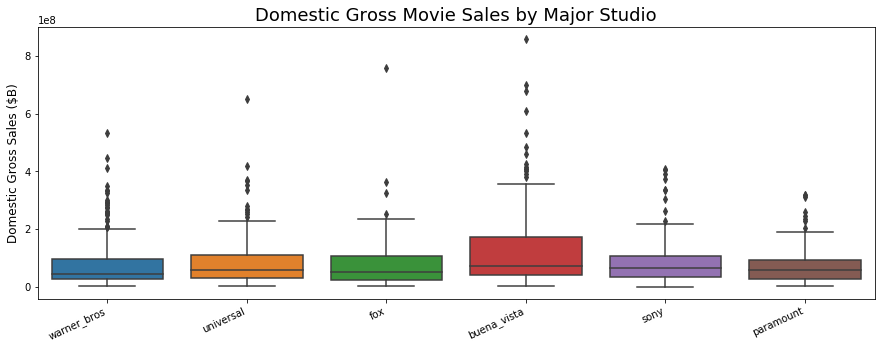

In [18]:
studio_list = ['warner_bros','universal','fox','buena_vista','sony','paramount']
studio_df = movies[studio_list]

for studio in studio_list:
    studio_df[studio] = studio_df[studio] * movies['domesticgross']

studio_melt = studio_df.melt()
studio_melt = studio_melt[studio_melt['value']!=0]

plt.figure(figsize=(15, 5))
sns.boxplot(data=studio_melt, y="value", x="variable")
plt.xticks(rotation=25, horizontalalignment='right')
plt.title("Domestic Gross Movie Sales by Major Studio", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/studio_sales.png')

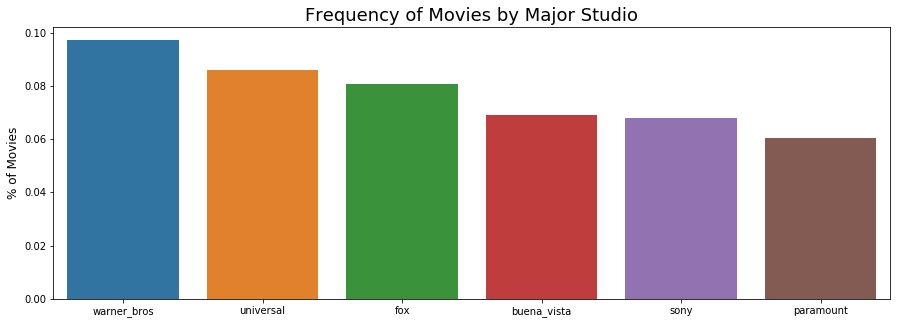

In [19]:
studio_list = ['warner_bros','universal','fox','buena_vista','sony','paramount']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[studio_list].melt(), y="value", x="variable", ci=None) 
plt.title("Frequency of Movies by Major Studio", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('plots/studio_freq.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


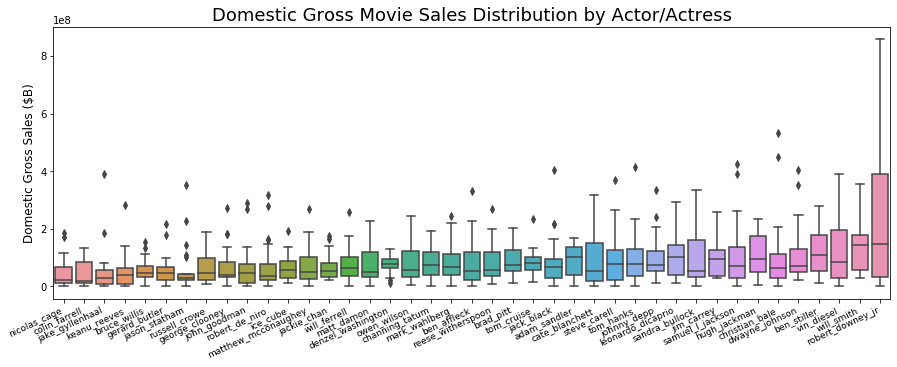

In [20]:
actor_list = ['matt_damon','nicolas_cage', 'owen_wilson', 'samuel_l_jackson', 'mark_wahlberg',
       'adam_sandler', 'denzel_washington', 'dwayne_johnson', 'gerard_butler',
       'george_clooney', 'ben_stiller', 'robert_de_niro', 'bruce_willis',
       'will_smith', 'ben_affleck', 'will_ferrell', 'tom_hanks', 'tom_cruise',
       'keanu_reeves', 'leonardo_dicaprio', 'jake_gyllenhaal', 'steve_carell',
       'johnny_depp', 'matthew_mcconaughey', 'jason_statham', 'vin_diesel',
       'robert_downey_jr', 'christian_bale', 'reese_witherspoon',
       'russell_crowe', 'ice_cube', 'sandra_bullock', 'jackie_chan',
       'cate_blanchett', 'brad_pitt', 'john_goodman', 'channing_tatum',
       'jim_carrey', 'jack_black', 'colin_farrell', 'hugh_jackman']
actor_df = movies[actor_list]

for actor in actor_list:
    actor_df[actor] = actor_df[actor] * movies['domesticgross']

actor_melt = actor_df.melt()
actor_melt = actor_melt[actor_melt['value']!=0]
result = actor_melt.groupby(['variable'])['value'].aggregate(np.mean).reset_index().sort_values('value')

plt.figure(figsize=(15, 5))
sns.boxplot(data=actor_melt, y="value", x="variable", order=result['variable'])
plt.xticks(rotation=25, horizontalalignment='right', fontsize=9)
plt.title("Domestic Gross Movie Sales Distribution by Actor/Actress", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/actor_sales.png')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


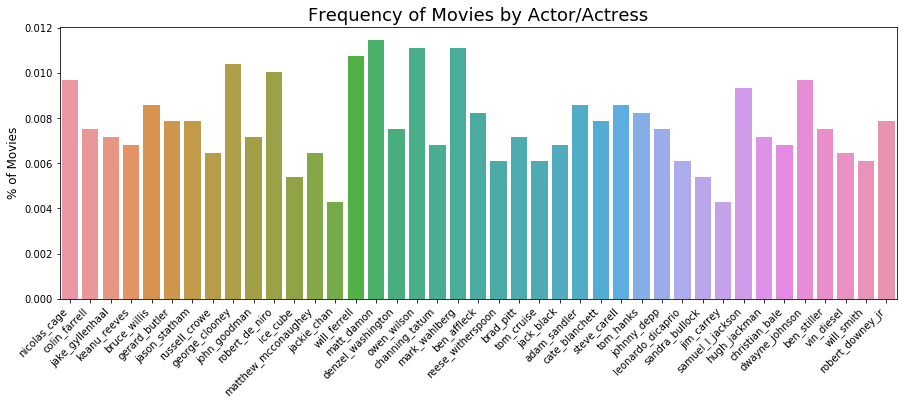

In [21]:
actor_list = ['matt_damon','nicolas_cage', 'owen_wilson', 'samuel_l_jackson', 'mark_wahlberg',
       'adam_sandler', 'denzel_washington', 'dwayne_johnson', 'gerard_butler',
       'george_clooney', 'ben_stiller', 'robert_de_niro', 'bruce_willis',
       'will_smith', 'ben_affleck', 'will_ferrell', 'tom_hanks', 'tom_cruise',
       'keanu_reeves', 'leonardo_dicaprio', 'jake_gyllenhaal', 'steve_carell',
       'johnny_depp', 'matthew_mcconaughey', 'jason_statham', 'vin_diesel',
       'robert_downey_jr', 'christian_bale', 'reese_witherspoon',
       'russell_crowe', 'ice_cube', 'sandra_bullock', 'jackie_chan',
       'cate_blanchett', 'brad_pitt', 'john_goodman', 'channing_tatum',
       'jim_carrey', 'jack_black', 'colin_farrell', 'hugh_jackman']

actor_df = movies[actor_list]

for actor in actor_list:
    actor_df[actor] = actor_df[actor] * movies['domesticgross']

actor_melt = actor_df.melt()
actor_melt = actor_melt[actor_melt['value']!=0]
result = actor_melt.groupby(['variable'])['value'].aggregate(np.mean).reset_index().sort_values('value')

plt.figure(figsize=(15, 5))
sns.barplot(data=movies[actor_list].melt(), y="value", x="variable", ci=None, order=result['variable']) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movies by Actor/Actress", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('plots/actor_freq.png')

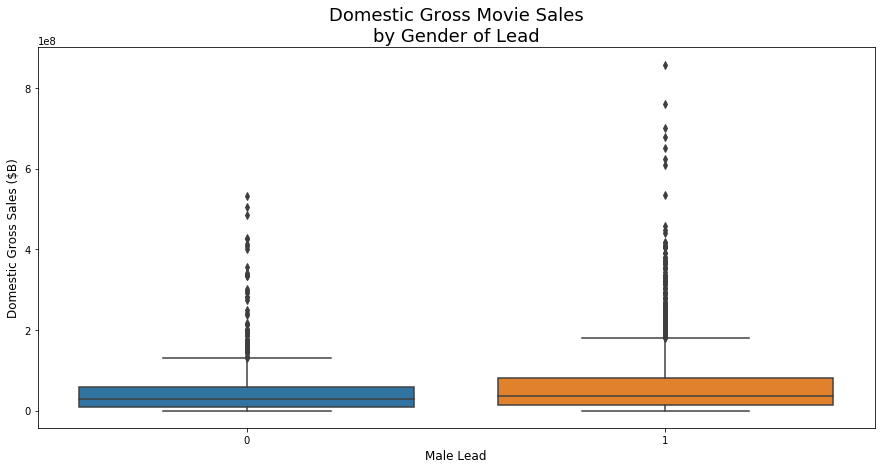

In [22]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=movies, y="domesticgross", x="male_lead")
plt.title("Domestic Gross Movie Sales\nby Gender of Lead", fontsize=18)
plt.xlabel("Male Lead", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/box_by_lead_gender.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


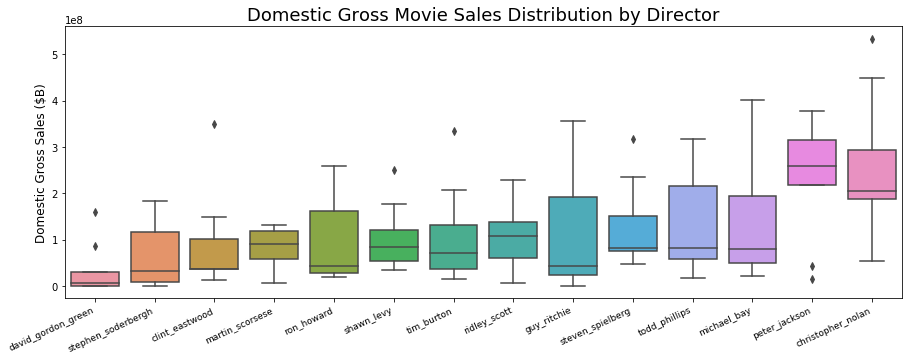

In [23]:
director_list = ['stephen_soderbergh', 'ridley_scott', 'steven_spielberg', 'ron_howard',
       'tim_burton', 'clint_eastwood', 'shawn_levy', 'michael_bay',
       'm_night_shyamalan', 'martin_scorsese', 'peter_jackson', 'guy_ritchie',
       'david_gordon_green', 'christopher_nolan', 'todd_phillips']
director_df = movies[director_list]

for director in director_list:
    director_df[director] = director_df[director] * movies['domesticgross']

director_melt = director_df.melt()
director_melt = director_melt[director_melt['value']!=0]
result = director_melt.groupby(['variable'])['value'].aggregate(np.mean).reset_index().sort_values('value')

plt.figure(figsize=(15, 5))
sns.boxplot(data=director_melt, y="value", x="variable", order=result['variable'])
plt.xticks(rotation=25, horizontalalignment='right', fontsize=9)
plt.title("Domestic Gross Movie Sales Distribution by Director", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/director_sales.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


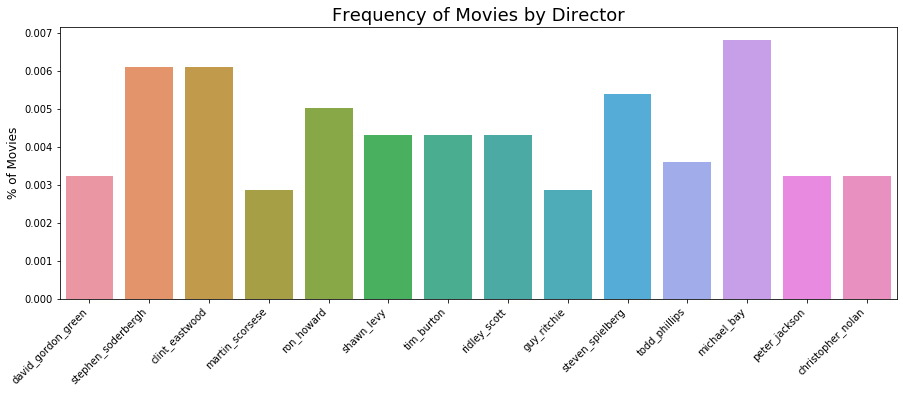

In [24]:
director_list = ['stephen_soderbergh', 'ridley_scott', 'steven_spielberg', 'ron_howard',
       'tim_burton', 'clint_eastwood', 'shawn_levy', 'michael_bay',
       'm_night_shyamalan', 'martin_scorsese', 'peter_jackson', 'guy_ritchie',
       'david_gordon_green', 'christopher_nolan', 'todd_phillips']

director_df = movies[director_list]

for director in director_list:
    director_df[director] = director_df[director] * movies['domesticgross']

director_melt = director_df.melt()
director_melt = director_melt[director_melt['value']!=0]
result = director_melt.groupby(['variable'])['value'].aggregate(np.mean).reset_index().sort_values('value')

plt.figure(figsize=(15, 5))
sns.barplot(data=movies[director_list].melt(), y="value", x="variable", ci=None, order=result['variable']) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movies by Director", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('plots/director_freq.png')

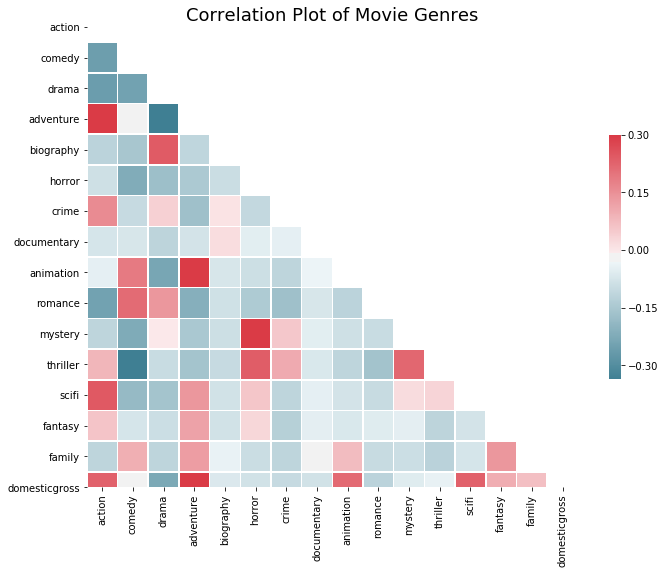

In [25]:
# Compute the correlation matrix
corr = movies[genre_list + ['domesticgross']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=1, yticklabels=1,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.title("Correlation Plot of Movie Genres", fontsize=18)
plt.savefig('plots/genre_corr.png')

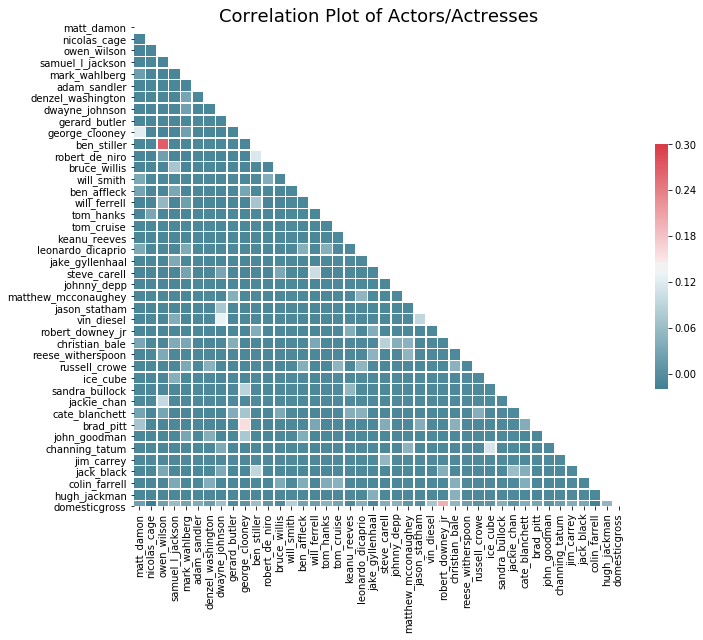

In [26]:
# Compute the correlation matrix
corr = movies[actor_list + ['domesticgross']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=1, yticklabels=1,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.title("Correlation Plot of Actors/Actresses", fontsize=18)
plt.savefig('plots/actor_corr.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

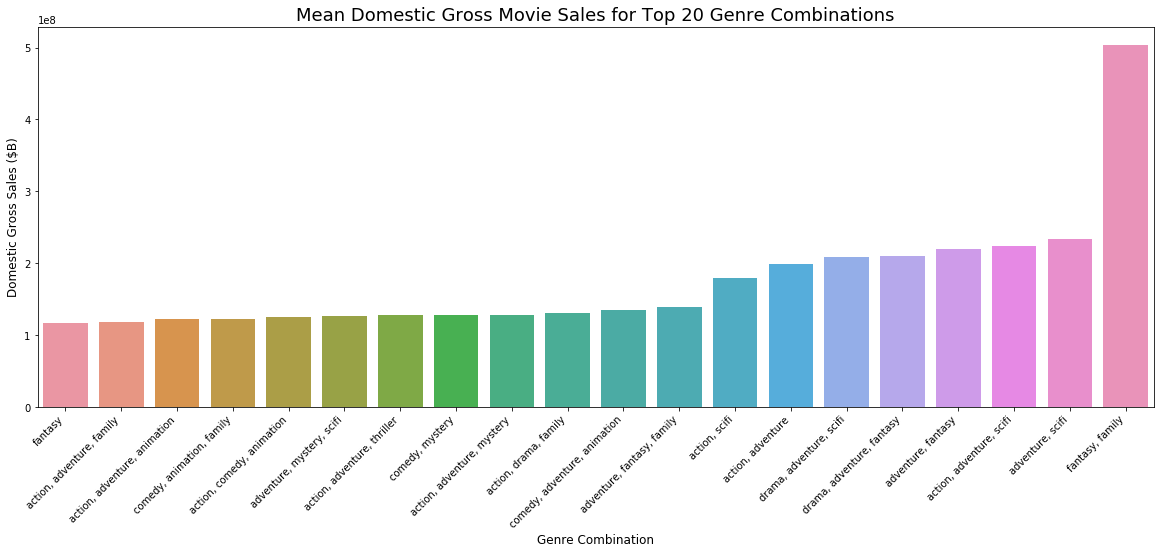

In [27]:
movie_genres = movies[genre_list]
movie_genres.sort_values(by=genre_list, axis=0, inplace=True)

composite = []
for index, row in movie_genres.iterrows():
    comp_value = ''
    for label, content in movie_genres.iteritems():
        if row[label] == 1:
            comp_value = comp_value + label + ', '
    comp_value = comp_value[:-2]
    composite.append(comp_value)

movie_genres['genres'] = composite
movie_genres['domesticgross'] = movies['domesticgross']
movie_genres.head(100)

result = movie_genres.groupby(['genres'])['domesticgross'].aggregate(np.mean).reset_index().sort_values('domesticgross')

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45, horizontalalignment='right')
sns.barplot(data=result.tail(20), y="domesticgross", x="genres", ci=False)
plt.title("Mean Domestic Gross Movie Sales for Top 20 Genre Combinations", fontsize=18)
plt.xlabel("Genre Combination", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/genre_combo_sales.png')

In [74]:
movie_genres['genres'].value_counts()

drama                                141
comedy                               140
comedy, drama                        131
comedy, drama, romance               131
comedy, romance                      129
comedy, adventure, animation         117
drama, romance                       100
drama, biography                      96
action, adventure, scifi              79
action, drama, crime                  69
horror, mystery, thriller             56
action, adventure, fantasy            53
action, comedy, adventure             51
action, comedy, crime                 47
action, crime, thriller               44
drama, crime, mystery                 42
drama, crime, thriller                40
documentary                           39
drama, thriller                       38
action, drama, adventure              36
horror, thriller                      36
comedy, crime                         34
drama, biography, crime               30
comedy, adventure, family             30
action, adventur

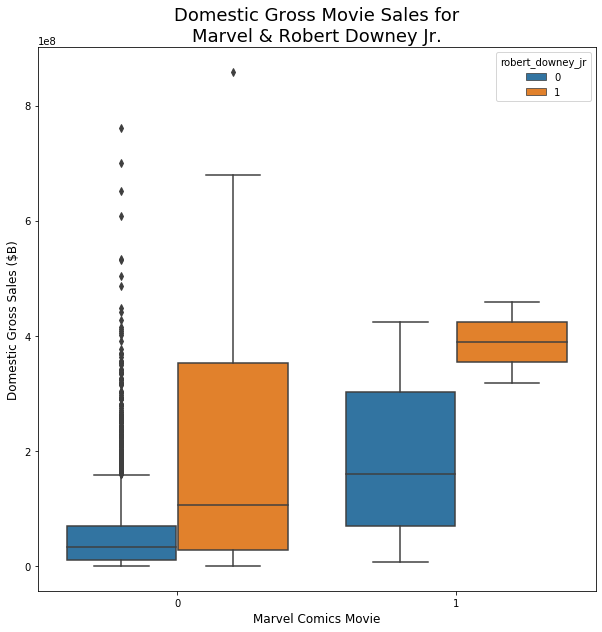

In [28]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="marvelcomics", hue="robert_downey_jr")
plt.title("Domestic Gross Movie Sales for\nMarvel & Robert Downey Jr.", fontsize=18)
plt.xlabel("Marvel Comics Movie", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/marvel_rdjr.png')

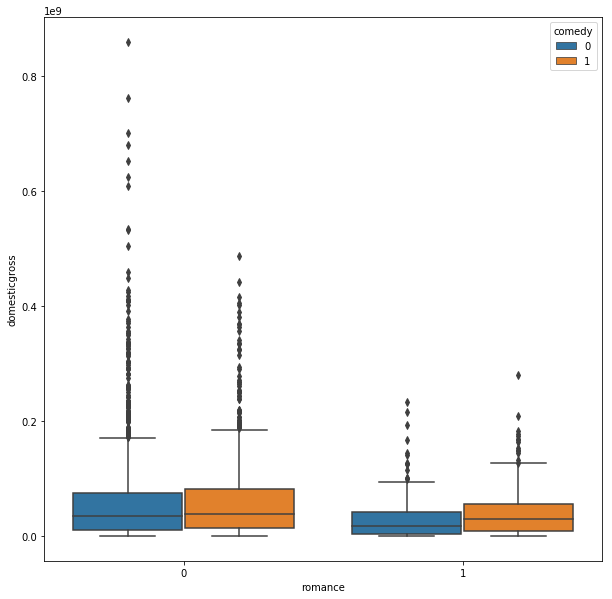

In [30]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="romance", hue="comedy")

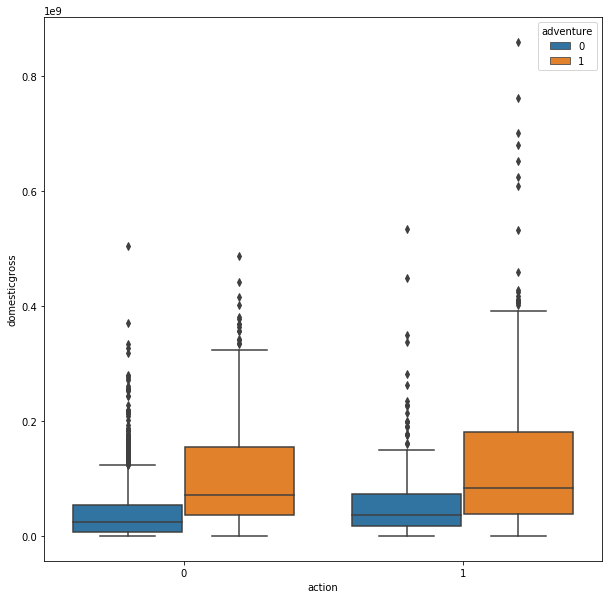

In [31]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="action", hue="adventure")

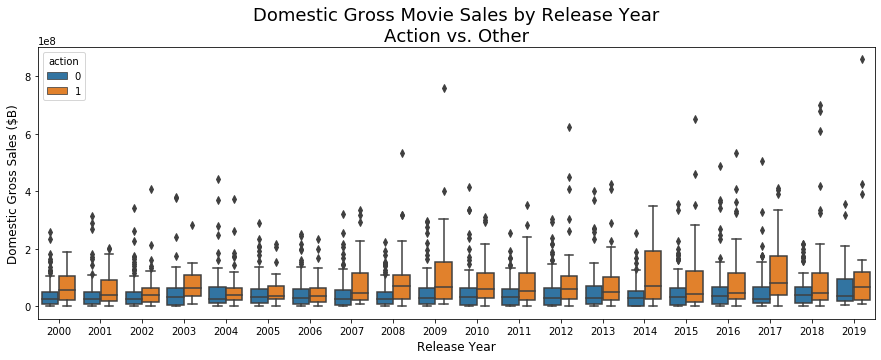

In [29]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="action")
plt.title("Domestic Gross Movie Sales by Release Year\nAction vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/action_by_year.png')

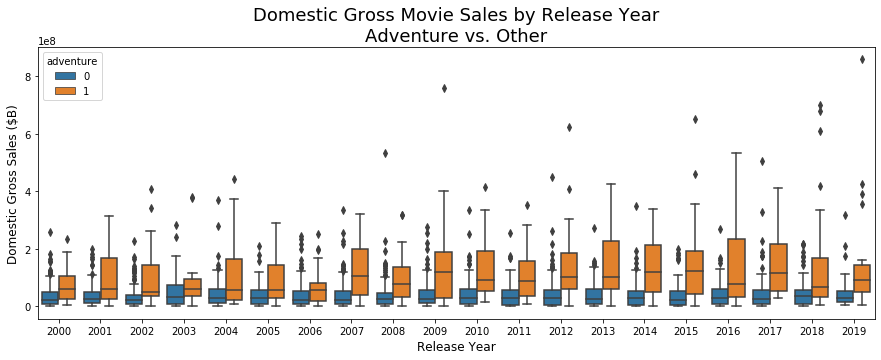

In [30]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="adventure")
plt.title("Domestic Gross Movie Sales by Release Year\nAdventure vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/adventure_by_year.png')

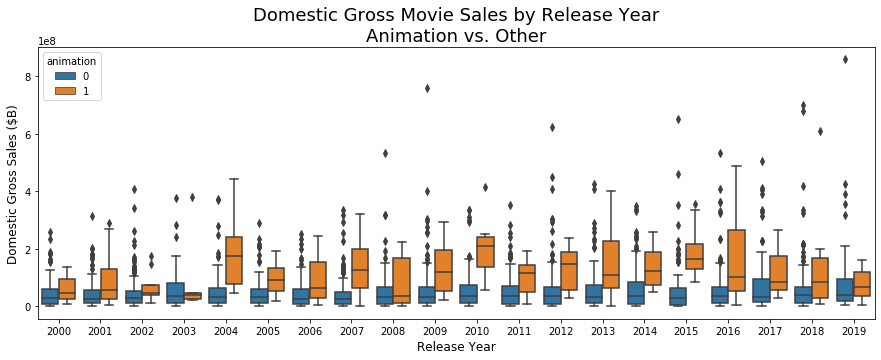

In [31]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="animation")
plt.title("Domestic Gross Movie Sales by Release Year\nAnimation vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/animation_by_year.png')

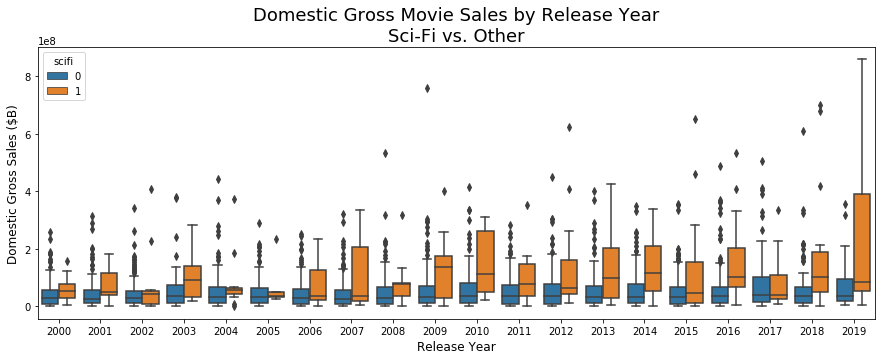

In [32]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="scifi")
plt.title("Domestic Gross Movie Sales by Release Year\nSci-Fi vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/scifi_by_year.png')

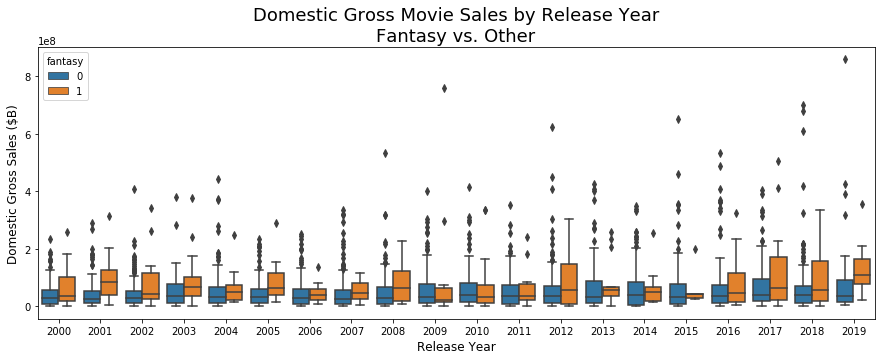

In [33]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="fantasy")
plt.title("Domestic Gross Movie Sales by Release Year\nFantasy vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/fantasy_by_year.png')

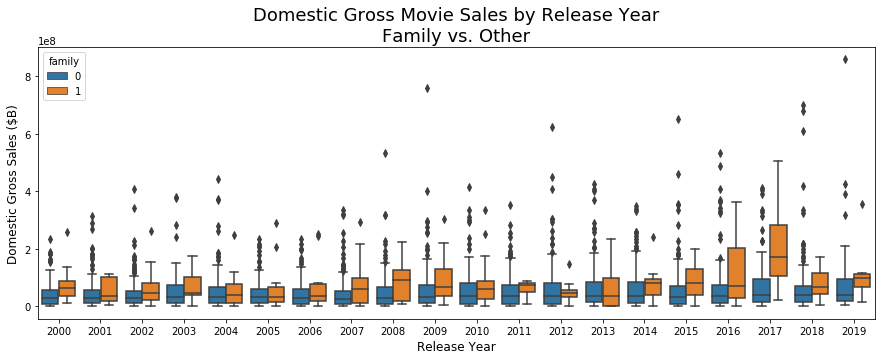

In [34]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="family")
plt.title("Domestic Gross Movie Sales by Release Year\nFamily vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/family_by_year.png')

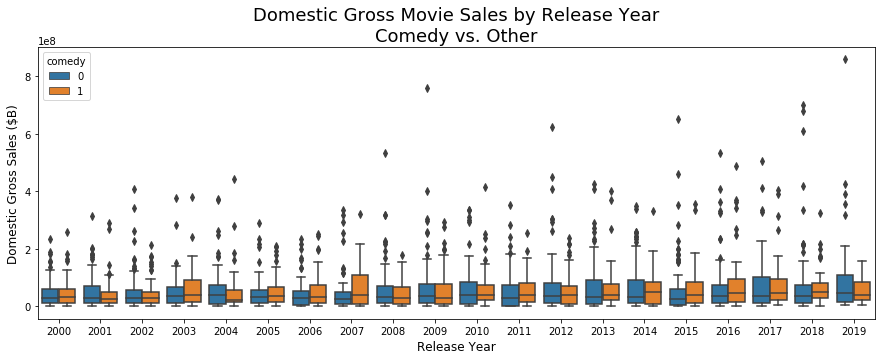

In [35]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="comedy")
plt.title("Domestic Gross Movie Sales by Release Year\nComedy vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/comedy_by_year.png')

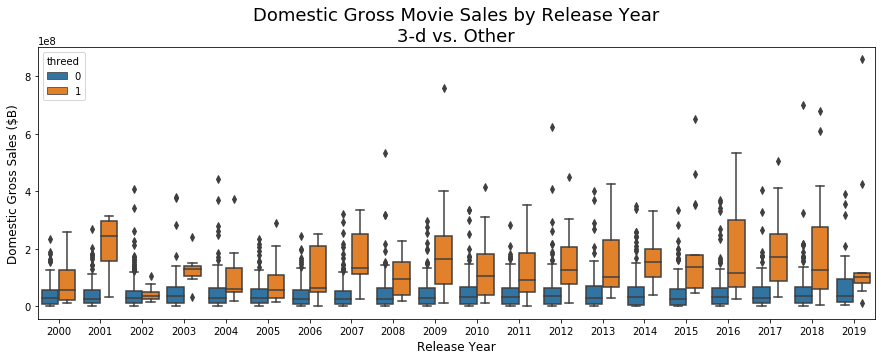

In [36]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="threed")
plt.title("Domestic Gross Movie Sales by Release Year\n3-d vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/3d_by_year.png')

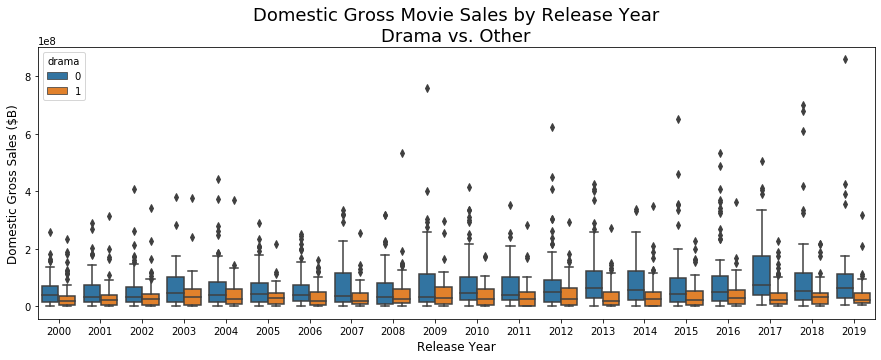

In [37]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year", hue="drama")
plt.title("Domestic Gross Movie Sales by Release Year\nDrama vs. Other", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('plots/drama_by_year.png')